In [2]:
import os,sys
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

%matplotlib inline 
sns.set_style('darkgrid')

In [3]:
data_file = 'experiment_result.xlsx'
df = pd.read_excel(data_file,sheet_name='all_tas',index_col=0)
print(df)

     Fold  Train_sig  Test_sig  Train_drug  Test_drug  MOAEMB  DrSim  SigMat  \
ALL     0      40810     17696         628        293    7449   6943    6854   
ALL     1      39504     19002         606        315    7600   6760    7071   
ALL     2      36698     21808         608        313    9700   8665    9128   

       RF  GSEA  ssCmap  Xcosine  Xsum  L1000CDS  Euclidean  Jaccard  Random  
ALL  6918  5325    5365     5412  3394      5325       5099     5420     475  
ALL  6375  5622    5332     5783  4125      5622       5299     5798     502  
ALL  8770  7686    7346     7640  6054      7686       7355     7946     718  


In [4]:
##################
# accuracy data
def save_label_dict(data_info_dir):
    moa_label_file = '{}/Huang_MOA_label.xlsx'.format(data_info_dir)
    compounds_info_file = '{}/compoundinfo_beta.txt'.format(data_info_dir)
    level5_sig_info_file = '{}/siginfo_beta.txt'.format(data_info_dir)

    # moa label file
    moa_df = pd.read_excel(moa_label_file, header=1)
    print('#'*50)
    print('### MOA file have {} drugs'.format(moa_df.shape[0]))
    moa_number = len(set(moa_df['MOA']))
    print('### MOA file have {} moas'.format(moa_number))
    moa_counts = moa_df['MOA'].value_counts()
    large_3drugs_moa = moa_counts[moa_counts>=3]
    print('### MOA file have {} moas large 3 drugs'.format(large_3drugs_moa.shape[0]))
    moa_df = moa_df[moa_df['MOA'].isin(large_3drugs_moa.index)]
    print('### MOA file have {} drugs'.format(moa_df.shape[0]))
    moa_number = len(set(moa_df['MOA']))
    print('### MOA file have {} moas'.format(moa_number))

    # compounds file
    cp_info_df = pd.read_csv(compounds_info_file, sep='\t')
    print('#'*50)
    print(('### here {} drugs record in CLUE databse'.format(cp_info_df.shape[0])))
    cp_info_df = cp_info_df[['pert_id', 'canonical_smiles']]
    cp_info_df = cp_info_df.drop_duplicates()
    cp_info_df = cp_info_df.dropna()
    print('### there are {} compounds with smile and NA'.format(cp_info_df.shape[0]))
    cp_info_df = cp_info_df[cp_info_df['canonical_smiles'] != 'restricted']
    print('### there are {} compounds with smiles'.format(cp_info_df.shape[0]))


    # Cmap level5 file
    level5_info_df = pd.read_csv(level5_sig_info_file, sep='\t', low_memory=False)
    level5_info_df = level5_info_df[level5_info_df['pert_type'] == 'trt_cp']
    print('#' * 50)
    print('### There are {} compounds signatures in level5'.format(level5_info_df.shape[0]))

    level5_info_df = level5_info_df[level5_info_df['pert_id'].isin(moa_df['BRD-ID'])]
    print('### There are {} compounds signatures in level5 with moas'.format(level5_info_df.shape[0]))
    level5_info_df = level5_info_df[level5_info_df['pert_id'].isin(cp_info_df['pert_id'])]
    print('### There are {} compounds signatures with simles in level5'.format(level5_info_df.shape[0]))
    level5_info_df = level5_info_df[level5_info_df['is_hiq'] == 1]
    print('### There are {} compounds signatures high quality'.format(level5_info_df.shape[0]))


    # save label file
    drug2moa_dict = dict(zip(list(moa_df['BRD-ID']), (moa_df['MOA'])))
    sig2drugmoa_dict = {}
    level5_info_df['moa'] = level5_info_df['pert_id'].map(drug2moa_dict)
    for id, row in level5_info_df.iterrows():
        sig2drugmoa_dict[row['sig_id']] = [row['pert_id'], row['moa']]

    return moa_df,level5_info_df,sig2drugmoa_dict,drug2moa_dict


data_dir = '/home/jlk/Project/111_Cmap/MOA/data/'
data_info_dir = '{}/01_Info_file/'.format(data_dir)
data_all_dir = '{}/02_All_data/'.format(data_dir)
data_cell_dir = '{}/03_Single_Cell/'.format(data_dir)

moa_df,level5_info_df,sig2drugmoa_dict,drug2moa_dict = save_label_dict(data_info_dir)
print(moa_df)

##################################################
### MOA file have 2597 drugs
### MOA file have 213 moas
### MOA file have 167 moas large 3 drugs
### MOA file have 2519 drugs
### MOA file have 167 moas
##################################################
### here 39321 drugs record in CLUE databse
### there are 28634 compounds with smile and NA
### there are 28618 compounds with smiles
##################################################
### There are 720216 compounds signatures in level5
### There are 300392 compounds signatures in level5 with moas
### There are 300258 compounds signatures with simles in level5
### There are 62374 compounds signatures high quality
                 BRD-ID                 Drug name              MOA
0         BRD-K76908866                 CP-724714           EGFR-i
1         BRD-K85606544                 neratinib           EGFR-i
2         BRD-K78431006                crizotinib            ALK-i
3         BRD-K59369769                tozasertib      Auror

In [5]:
##################
# accuracy data
methods = ['MOAEMB','DrSim','SigMat','RF',
           'GSEA','ssCmap','Xcosine','Xsum',
           'Euclidean','L1000CDS','Jaccard','Random']
methods_belong = {'MOAEMB':'MOAEMB','DrSim':'Machine learning','SigMat':'Machine learning','RF':'Machine learning',
           'GSEA':'Biology','ssCmap':'Biology','Xcosine':'Biology','Xsum':'Biology',
           'Euclidean':'Distance','L1000CDS':'Distance','Jaccard':'Distance','Random':'Random'}

### acc plot data
df = df.loc[['ALL']]
acc_sig = []
acc_val = []
tests = []
labels = []
folds = []
kinds = []
for method in methods:
    for fold in [0,1,2]:
        acc = df[df['Fold']==fold][method].values[0]
        acc_sig.append(acc)
        Test = df[df['Fold']==fold]['Test_sig'].values[0]
        tests.append(Test)
        acc_val.append(acc/Test)
        labels.append(method)
        folds.append(fold)
        kinds.append(methods_belong[method])
plot_df = pd.DataFrame()
plot_df['test'] = tests
plot_df['method'] = labels
plot_df['fold'] = folds
plot_df['correct signatures'] = acc_sig
plot_df['accuracy'] = acc_val
plot_df['kind'] = kinds

In [6]:
low_num = level5_info_df[level5_info_df['tas']<=0.2].shape[0]
high_num = level5_info_df[level5_info_df['tas']>0.2].shape[0]
all_num = level5_info_df.shape[0]
print(low_num,high_num,all_num,low_num/all_num,high_num/all_num)

17797 44577 62374 0.2853272196748645 0.7146727803251355


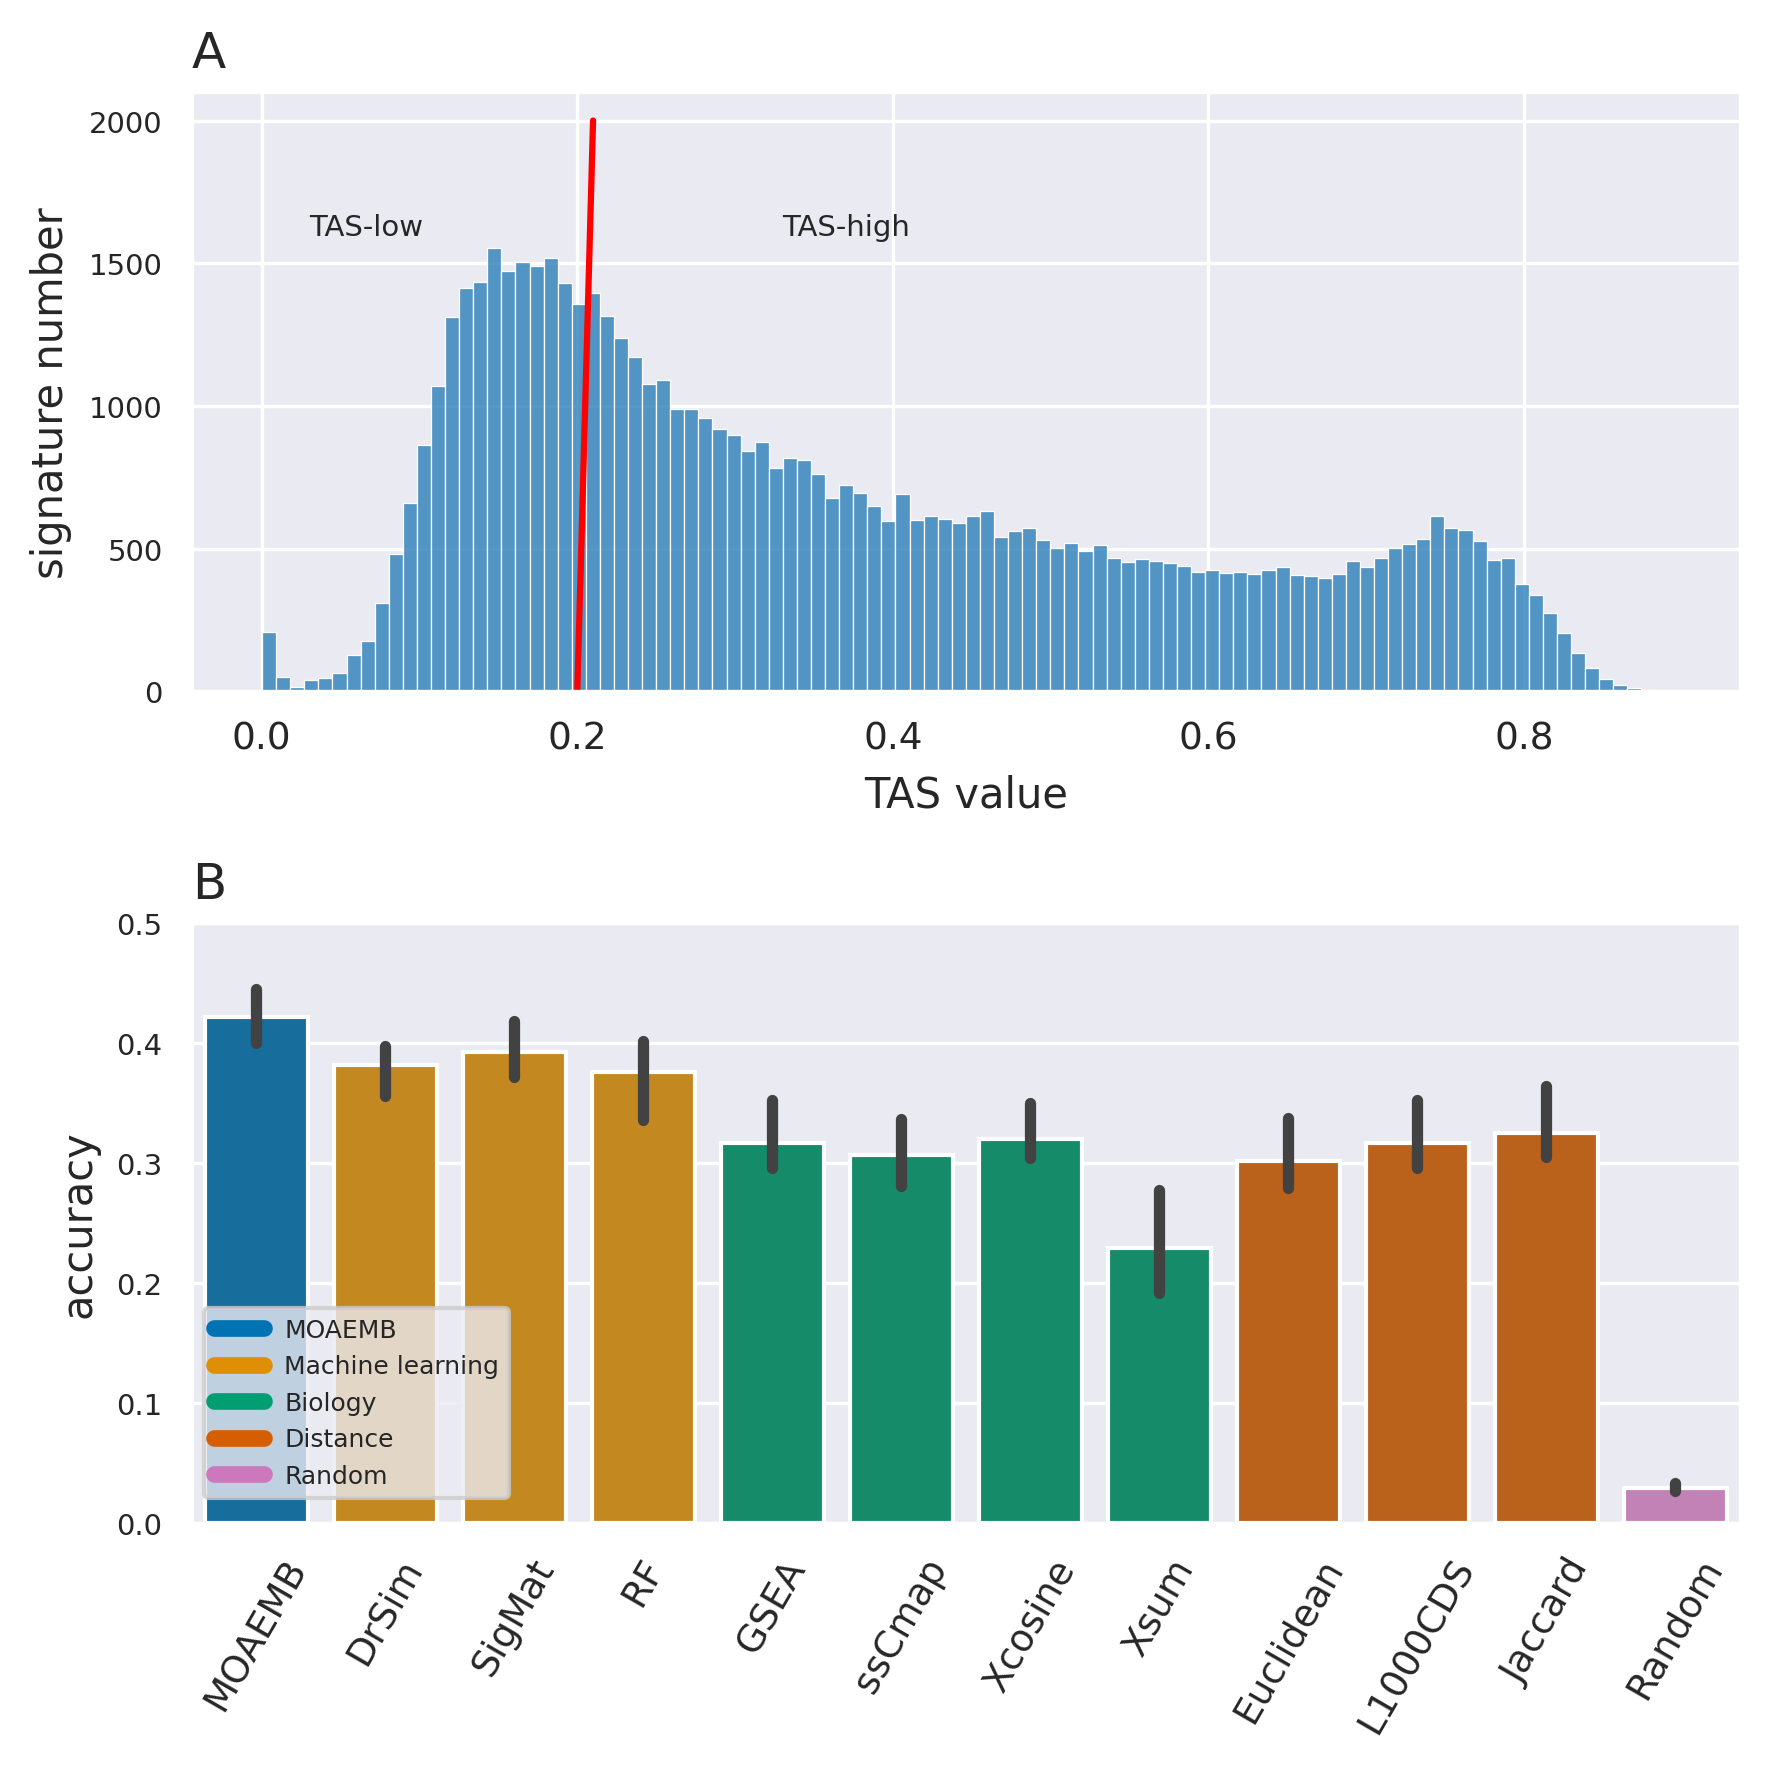

In [9]:
### plot color
cols = []
cols_kind = ['MOAEMB','Machine learning','Biology','Distance','Random']
col_pal = sns.color_palette("colorblind")
for method in methods:
    for i in range(len(cols_kind)):
        color = col_pal[i]
        kind = cols_kind[i]
        if methods_belong[method] == kind:
            cols.append(color)
            
my_dpi=300
plt.figure(figsize=(6,6),dpi=my_dpi)

##################
# tas
ax1 = plt.subplot(2,1,1)
sns.histplot(level5_info_df['tas'].sort_values(),bins=100,ax=ax1).set(
    xlabel='TAS value',ylabel='signature number')
plt.plot([0.2,0.21],[0,2000],color='red')
plt.yticks(fontsize=7)
plt.xticks(fontsize=9)
plt.title('A',loc='left')
plt.text(0.03, 1600, 'TAS-low', fontsize=7)
plt.text(0.33, 1600, 'TAS-high', fontsize=7)


# ##################
# # accuracy
ax3 = plt.subplot(2,1,2)
sns.barplot(x='method',y='accuracy',data=plot_df,palette=cols,ax=ax3).set(xlabel=None)
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5],fontsize=7)
custom_lines = [Line2D([0], [0], color=col_pal[0], lw=4),
                Line2D([0], [0], color=col_pal[1], lw=4),
                Line2D([0], [0], color=col_pal[2], lw=4),
                Line2D([0], [0], color=col_pal[3], lw=4),
                Line2D([0], [0], color=col_pal[4], lw=4)]
ax3.legend(custom_lines, cols_kind,bbox_to_anchor=(0, 0.2), loc='center left',fontsize=6)
plt.yticks(fontsize=7)
plt.xticks(rotation=60,fontsize=9)

plt.title('B',loc='left')
plt.tight_layout()
# plt.show()
plt.savefig('Figure5.jpg')

In [10]:
tas_df = level5_info_df[['sig_id','pert_id','tas']]
tas_df['moa'] = tas_df['pert_id'].map(drug2moa_dict) 

large_moa = tas_df['moa'].value_counts()
tas_df = tas_df[tas_df['moa'].isin(large_moa[large_moa>100].index)]

moa_mean_tas_df = tas_df.groupby('moa').agg('mean')
sort_moa_mean_tas_df = moa_mean_tas_df['tas'].sort_values(ascending=False)
top10_moa = sort_moa_mean_tas_df.head(10)


<ipython-input-10-601295a42c0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tas_df['moa'] = tas_df['pert_id'].map(drug2moa_dict)


In [11]:
name_dict = {"HDAC-i":"HDAC-inhibitor",
             "HSP-i":"HSP-inhibitor",
             "MEK/ERK-i":"MEK-inhibitor",
             "PKC-activator":"PKC-activator",
             "Topo-i":"Topoisomerase-inhibitor",
             "antimetabolite":"anti-metabolite",
             "antimicrotubule":"anti-microtubule",
             "retinoid":"retinoid-receptor-agonist",
             "proteasome inh.":"proteasome inhibitor",
             "mTOR-i":"mTOR-inhibitor",
             "protein syn. inh.":"protein synthesis inhibitor",
             "cardiac glycoside":"cardiac glycoside",
             "ER stressor":"ER stressor",
             "CDK-i":"CDK-inhibitor"
            }

df = pd.DataFrame()

moa_per_file = '/home/jlk/Project/111_Cmap/MOA/src/moa_high_0.csv'
df0 = pd.read_csv(moa_per_file)
df0['fold'] = 0


moa_per_file = '/home/jlk/Project/111_Cmap/MOA/src/moa_high_1.csv'
df1 = pd.read_csv(moa_per_file)
df1['fold'] = 1


moa_per_file = '/home/jlk/Project/111_Cmap/MOA/src/moa_high_2.csv'
df2 = pd.read_csv(moa_per_file)
df2['fold'] = 2

df = pd.concat([df0,df1,df2])
print(df)
df_dict = {}
for i in top10_moa.index:
    sub_df = df[df['moa']==i]
    sub_all = sub_df['number'].sum()
    sub_find = sub_df['find'].sum()
    print(i,sub_all,sub_find,sub_find/sub_all)
    df_dict[name_dict[i]] = [round(top10_moa[i],2),round(sub_find/sub_all,4)]

final_df = pd.DataFrame(df_dict).T
final_df.columns = ['TAS','accuracy']
print(final_df)
final_df.to_csv('top10_tas.csv')

     Unnamed: 0                moa  number  find    per  fold
0             0     5-HT modulator      78     1   1.28     0
1             1           ACE inh.      36     0   0.00     0
2             2              AIIRA      62     0   0.00     0
3             3              ALK-i      81     3   3.70     0
4             4         AR agonist      14     0   0.00     0
..          ...                ...     ...   ...    ...   ...
125         125          uncoupler      27     3  11.11     2
126         126         uricosuric      29     0   0.00     2
127         127             vit. B      26     0   0.00     2
128         128  vit. K antagonist      10     0   0.00     2
129         129           xanthine      24     0   0.00     2

[373 rows x 6 columns]
proteasome inh. 3896 3817 0.9797227926078029
protein syn. inh. 217 162 0.7465437788018433
cardiac glycoside 258 231 0.8953488372093024
HDAC-i 4443 4219 0.9495836146747693
Topo-i 2124 1510 0.7109227871939736
HSP-i 1968 1761 0.8948170